In [1]:
import os
import torch
import argparse
import json
from train_sample_utils import get_models, get_DDPM

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/pytorch/lib/python3.9/site-packages/horovod/common/util.py:258: UserWarning: Framework pytorch installed with version 1.12.0 but found version 1.12.1+cu116.
             This can result in unexpected behavior including runtime errors.
             Reinstall Horovod using `pip install --no-cache-dir` to build with the new version.
  warnings.warn(get_version_mismatch_message(name, version, installed_version))


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '-c', '--config', type=str, 
    default='config/train.json')

''' parser configs '''
args_raw = parser.parse_args(['-c', 'configs/laion_cocostuff_text_v9.json'])
with open(args_raw.config, 'r') as IN:
    args = json.load(IN)
args.update(vars(args_raw))
args['gpu_ids'] = [1] # DEBUG
expt_name = args['expt_name']
expt_dir = args['expt_dir']
expt_path = os.path.join(expt_dir, expt_name)
os.makedirs(expt_path, exist_ok=True)

In [3]:
'''1. create denoising model'''
denoise_args = args['denoising_model']['model_args']
models = get_models(args)

diffusion_configs = args['diffusion']
# diffusion_args['beta_schedule_args']['n_timestep'] = 10 # DEBUG
ddpm_model = get_DDPM(
    diffusion_configs=diffusion_configs,
    log_args=args,
    **models
)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
INFO: initialize denoising UNet from pretrained_models/LAION_text2img/unet.ckpt, NOTE: without partial attention layers
INFO: initialize VQVAE from pretrained_models/LAION_text2img/vqvae.ckpt
INFO: initialize text model from pretrained_models/LAION_text2img/bert.ckpt


In [4]:
'''2. create a dataloader which generates'''
from test_sample_utils import get_test_dataset, get_test_callbacks
test_dataset, test_loader = get_test_dataset(args)

'''3. callbacks'''
callbacks = get_test_callbacks(args, expt_path)

called set_image_size (256, 256)
called set_image_size (256, 256)
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: '

In [5]:
ckpt_path = os.path.join(expt_path, 'latest.ckpt')
if os.path.exists(ckpt_path):
    print(f'INFO: Found checkpoint {ckpt_path}')
    ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
    ''' DEBUG '''
    # ckpt_denoise_fn = {k.replace('denoise_fn.', ''): v for k, v in ckpt.items() if 'denoise_fn' in k}
    # ddpm_model.denoise_fn.load_state_dict(ckpt_denoise_fn)
    ddpm_model.load_state_dict(ckpt)
else:
    ckpt_path = None
    raise RuntimeError('Cannot do inference without pretrained checkpoint')
ddpm_model = ddpm_model.cuda()

INFO: Found checkpoint experiments/laion_ldm_cocostuff_layout_caption_v9/latest.ckpt


In [6]:
import math
import numpy as np
from data.coco_detect import get_coco_id_mapping
coco_id_mapping = get_coco_id_mapping()
class ColorMapping():
    def __init__(self, id_class_mapping, mesh_dim=3):
        self.id_class_mapping = id_class_mapping
        num_classes = len(id_class_mapping)
        num_grid_each_dim = math.ceil(num_classes**(1/mesh_dim))
        mesh_d = np.meshgrid(
            *[np.linspace(0,1,num_grid_each_dim)]*mesh_dim
        )
        mesh_d = [i.reshape(-1) for i in mesh_d]
        self.mesh = np.stack(mesh_d, axis=-1)

        self.id_to_mesh_idx = {}
        for idx, (class_id, class_name) in enumerate(id_class_mapping.items()):
            self.id_to_mesh_idx[class_id] = idx
    
    def __call__(self, class_id):
        class_name = self.id_class_mapping[class_id]
        mesh_index = self.id_to_mesh_idx[class_id]
        return self.mesh[mesh_index], class_name

In [7]:
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def format_image(x):
    x = x.cpu()
    x = (x + 1) / 2
    x = x.clamp(0, 1)
    assert len(x.shape) in [3, 4]
    if len(x.shape) == 3:
        x = x.permute(1,2,0).detach().numpy()
    else:
        if x.shape[0] == 1:
            x = x[0].permute(1,2,0).detach().numpy()
        else:
            x = make_grid(x)
            x = x.permute(1,2,0).detach().numpy()
    return x
def show_image(x):
    plt.imshow(format_image(x))

def plot_bounding_box(image, bboxes, label_mapping=coco_id_mapping):
    # bboxes: num_obj, 5
    color_mapper = ColorMapping(label_mapping)

    H, W = image.shape[:2]
    for bbox in bboxes:
        x, y, w, h = bbox[:4]
        x, y, w, h = list(map(int, [x*W, y*H, w*W, h*H]))
        label = int(bbox[-1]) + 1 if len(bbox) == 5 else None
        # in the network, we let label start from 0 by -1, now we add 1 back
        color, class_name = color_mapper(label)
        # plot the rectangle bounding box and label
        image = cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), color, 2)
        if label:
            (w, h), _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 1)
            image = cv2.rectangle(image, (x, y+20), (x + w, y), color, -1)
            cv2.putText(image, class_name, (x, y+18), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (1,1,1), 1)
    return image

def save_image(image, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    if image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)[..., ::-1]
    cv2.imwrite(save_path, image)

In [120]:
def get_mask(image_size, regions):
    canvas = torch.zeros((image_size, image_size))
    for region in regions:
        x, y, w, h = region
        x1 = int(torch.floor(x*image_size)) - 1
        y1 = int(torch.floor(y*image_size))
        x2 = int(torch.ceil((x+w)*image_size))
        y2 = int(torch.ceil((y+h)*image_size))
        canvas[y1:y2, x1:x2] = 1
    return canvas
def get_mask_from_bbox(image_size, bboxes, target_index):
    region = []
    for bbox in bboxes:
        x, y, w, h, index = bbox
        if int(index) in target_index:
            region.append([x, y, w, h])
    return get_mask(image_size, region)

In [141]:
objects_modify_config = [
    {
        'image_idx': 19,
        'obj_idx': 0,
        'obj_cls_idx': 12,
        'edit_type': 'shift',
        'dx': 0.5, 
        'dy': -0.3,
    },
    {
        'image_idx': 105,
        'obj_idx': 1,
        'obj_cls_idx': 61,
        'edit_type': 'shift',
        'dx': -0.3, 
        'dy': 0,
    },
    {
        'image_idx': 105,
        'obj_idx': 1,
        'obj_cls_idx': 61,
        'edit_type': 'remove',
    },
    {
        'image_idx': 105,
        'obj_idx': 1,
        'obj_cls_idx': 61,
        'edit_type': 'change',
        'new_cls_idx': 32 # suitcase
    }
]
object = objects_modify_config[2]
image_idx = object['image_idx']
obj_idx = object['obj_idx']
obj_cls_idx = object['obj_cls_idx']
edit_type = object['edit_type']
if edit_type == 'shift':
    dx = object['dx']
    dy = object['dy']
elif edit_type == 'change':
    new_cls_idx = object['new_cls_idx']

In [142]:
# add additional dim
batch = test_dataset[image_idx]
raw_x_0 = batch[0].cuda()[None]
# layout_context = torch.tensor(batch[1]).cuda()[None]
text = batch[2]
original_mask = get_mask_from_bbox(32, batch[1], [obj_cls_idx])

# modified layout
def move_obj(bbox, dx, dy):
    bbox[0] += dx; bbox[1] += dy
    return bbox
if edit_type == 'shift':
    obj_to_modify = batch[1].clone()[obj_idx]
    modified_obj = move_obj(obj_to_modify, dx, dy)
    modified_layouts = batch[1].clone()
    modified_layouts[obj_idx] = modified_obj
    modified_mask = get_mask_from_bbox(32, modified_layouts, [obj_cls_idx])
elif edit_type == 'remove':
    modified_layouts = batch[1].clone()
    modified_layouts = torch.cat([modified_layouts[0:obj_idx], modified_layouts[obj_idx+1:]], dim=0)
    modified_mask = torch.zeros_like(original_mask)
    text = text.replace(coco_id_mapping[obj_cls_idx+1], '')
elif edit_type == 'change':
    modified_layouts = batch[1].clone()
    modified_layouts[obj_idx][-1] = new_cls_idx
    modified_mask = torch.zeros_like(original_mask)
    text = text.replace(coco_id_mapping[obj_cls_idx+1], coco_id_mapping[new_cls_idx+1])
modified_layout_context = torch.tensor(modified_layouts).cuda()[None]

mask = 1 - torch.where(original_mask>.5, original_mask, modified_mask).cuda() # bitwise_or for float
# region == 1 to keep, retion == 0 to overwrite
print(text)

a chair and a umbrella that is on a beach,umbrella,chair,sand,sky-other,sea


/tmp/ipykernel_2965/3615231810.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  modified_layout_context = torch.tensor(modified_layouts).cuda()[None]


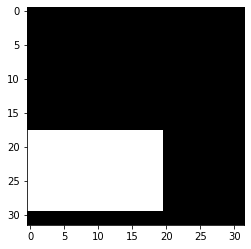

In [158]:
plt.imshow(1-mask.cpu(), cmap='gray')

In [144]:

model_kwargs = {'context': {
            'layout': modified_layout_context,
            'text': ddpm_model.encode_text([text])
        }
    }
uncondition_model_kwargs = {'context': {
            'layout': torch.empty((1, 0, 5)).cuda(),
            'text': ddpm_model.encode_text([''])
        }
    }

In [155]:
from DDIM_ldm.PLMSSampler import PLMSSampler as FastSampler
from model_utils import default
sampler = FastSampler(ddpm_model.denoise_fn, ddpm_model.beta_schedule_args)
x_0 = ddpm_model.encode_image_to_latent(raw_x_0)
y_0, y_t_hist = sampler.sample(
    S=ddpm_model.fast_sampling_steps,
    batch_size=1,
    x_T=torch.randn(1, 4, 32, 32).cuda(), # when x_T is given, shape is not used
    shape=[3, 64, 64],
    verbose=False,
    eta=0,
    model_kwargs=model_kwargs,
    uncondition_model_kwargs=uncondition_model_kwargs,
    guidance_scale=5.0,
    x0=x_0, # raw image after vqencode
    mask=mask # mask==1 to keep, mask==0 to overwrite
)
y_0 = ddpm_model.decode_latent_to_image(y_0)

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 100 timesteps


PLMS Sampler: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


/tmp/ipykernel_2965/32914162.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_annoed = plot_bounding_box(np.ones_like(image.copy()), torch.tensor(bboxes).numpy(), coco_id_mapping)


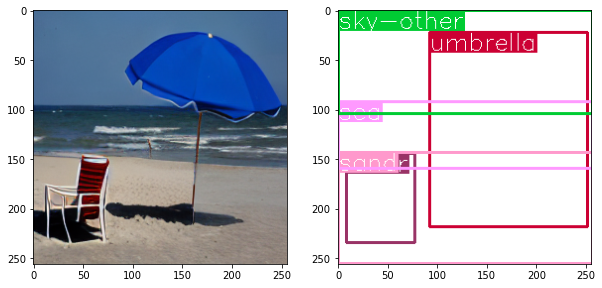

In [156]:
#start plot
image = format_image(y_0)
bboxes = modified_layouts
image_annoed = plot_bounding_box(np.ones_like(image.copy()), torch.tensor(bboxes).numpy(), coco_id_mapping)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[1].imshow(image_annoed)
# save_image(
#     image_annoed, 
#     save_path=os.path.join(expt_path, 'sampling', f'{idx:04d}.png')
# )

In [140]:
save_image(
    image, 
    save_path=os.path.join('tmp', 'shift_obj.png')
)
save_image(
    image_annoed, 
    save_path=os.path.join('tmp', 'shift_bbox_layout.png')
)

/tmp/ipykernel_2965/1632504296.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_annoed = plot_bounding_box(np.ones_like(image.copy()), torch.tensor(bboxes).numpy(), coco_id_mapping)


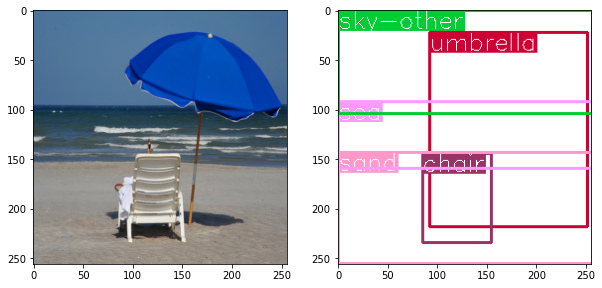

In [103]:
#start plot
image = format_image(raw_x_0)
bboxes = batch[1]
image_annoed = plot_bounding_box(np.ones_like(image.copy()), torch.tensor(bboxes).numpy(), coco_id_mapping)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[1].imshow(image_annoed)
plt.show()

In [104]:
save_image(
    image_annoed, 
    save_path=os.path.join('tmp', 'gt_bbox_layout.png')
)

In [ ]:
#### visualize prediction results